In [8]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from chain import *
import pickle

In [3]:
def sample_poisson(T, lbda):
    """
    sample a homogeneous poisson process with rate 'lbda' till time 'T'
    return the jumping times
    """
    n = np.random.poisson(lbda * T)
    jumps = np.sort(np.random.random(n) * T)
    endpoints = np.hstack(([0], jumps, [T]))
    return endpoints

In [4]:
class ihDDModel(object):
    def __init__(self, mu1, mu2, endpoints, sigma=1) -> None:
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma = sigma
        self.mu_t = lambda t: mu_pc(t, self.mu1, self.mu2, endpoints)
        
    def gen_datum(self, a, z, dt=0.001):
        t, u = 0, z
        while u > 0 and u < a:
            dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))
            u += self.mu_t(t) * dt + self.sigma * dW
            t += dt
        return np.hstack((t, (u > a / 2) * a))
    
    def gen_data(self, a, z, num=1000, dt=0.001):
        data = np.zeros((num, 2))
        for i in range(num):
            data[i] = self.gen_datum(a, z, dt)
        return data
    
    def gen_trajs(self, z, T, Nt=1000, num=10):
        """
        Use strong Euler to simulate
        only used for visualization
        """
        trajs = []
        t0, u0 = 0, z
        dt = (T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        for i in range(num):
            dW = np.sqrt(dt) * np.random.normal(size=(Nt + 1,))
            du = self.mu_t(t_grid) * dt + self.sigma * dW
            u_grid = z + np.cumsum(du)
            trajs.append(np.array([t_grid, u_grid]))
        return np.array(trajs)

#### Visualize

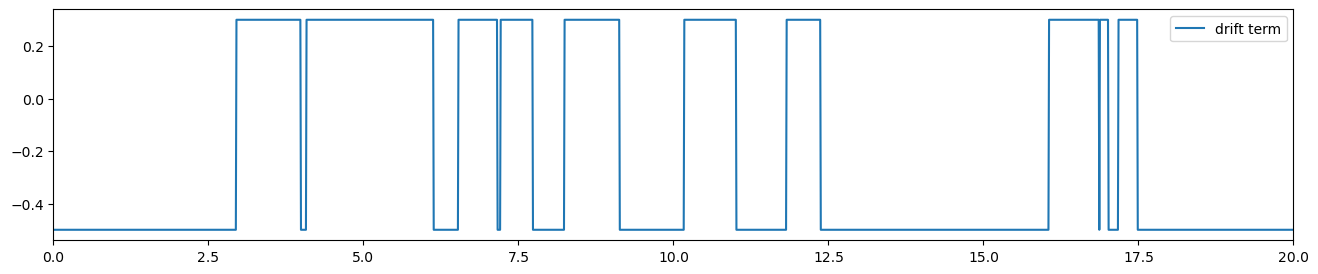

In [5]:
mu1 = -0.5
mu2 = 0.3
sigma = 1
a = 4.0
z = 1.5
T_end = 20

endpoints = sample_poisson(T_end, lbda=1)
ts = np.linspace(0, T_end, 2000)

fig, ax = plt.subplots(figsize=(16,3))
ax.plot(ts, mu_pc(ts, mu1, mu2, endpoints), label='drift term')
ax.legend(loc='upper right')
ax.autoscale(axis='x', tight=True)
plt.show()

In [6]:
ihddm = ihDDModel(mu1, mu2, endpoints=endpoints, sigma=sigma)
trajs = ihddm.gen_trajs(z, T_end, num=1000)
ts = np.linspace(0, T_end, 1000)
EX = []
for t in ts:
    EX.append(z + mut_pl(t, mu1, mu2, endpoints))
    
avg = np.mean(trajs[:,1,:], axis=0)

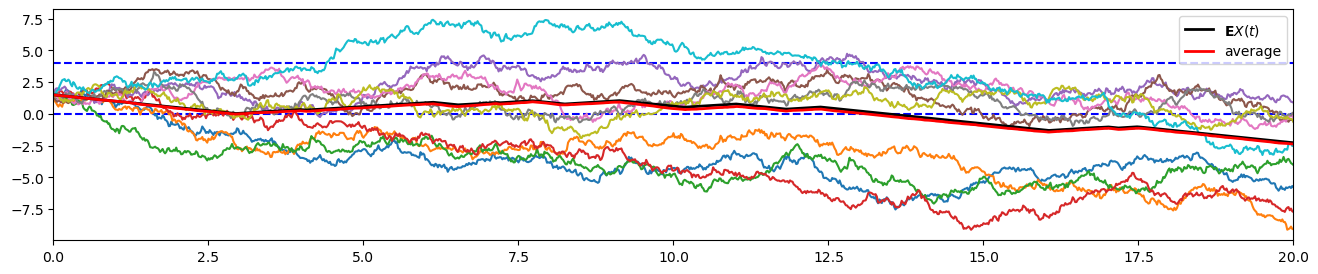

In [7]:
fig, ax = plt.subplots(figsize=(16,3))
ax.hlines(a, 0, T_end, colors='blue', linestyles='--')
ax.hlines(0, 0, T_end, colors='blue', linestyles='--')
for traj in trajs[:10]:
    ax.plot(traj[0], traj[1])
ax.plot(ts, np.array(EX), c='k', label=r'$\mathbf{E}X(t)$', lw=2)
ax.plot(ts, avg[:-1], c='r', label=r'average', lw=2)
ax.autoscale(axis='x', tight=True)
ax.legend()
plt.show()

#### Generate

In [15]:
mu1 = 0.5
mu2 = -0.3
sigma = 1
a = 4.0
z = 1.5
T_end = 30

In [20]:
num_data = 1000
data = np.zeros((num_data, 2))
intervals = []

for k in range(num_data):
    endpoints = sample_poisson(T_end, lbda=1)
    ihddm = ihDDModel(mu1, mu2, endpoints=endpoints, sigma=sigma)
    data[k] = ihddm.gen_datum(a, z)
    intervals.append(endpoints)


In [21]:
data.max()

22.43800000000444

In [24]:
with open("../Data/data_ih.pkl", "wb") as fp:
    pickle.dump([data, intervals], fp)
print('data saved!')